In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from windrose import WindroseAxes
import os


# Load the data 

In [3]:
output_dir = 'data'
COUNTRY_NAME = "sieraleone"
FILE_NAME = "sierraleone-bumbuna.csv"
try:
    df = pd.read_csv(f"./data/{FILE_NAME}", parse_dates=["Timestamp"])
    df = df.set_index("Timestamp")
except FileNotFoundError:
    print("Error: Can't find file")

# Summary Statistics & Missing-Value Report

In [4]:
print(df.describe())

print("\n")
# Missing Vals
print("--- Missing Values Report ---")
missing_vals = df.isnull().sum()
missing_percent = (missing_vals / len(df)) * 100
missing_df = pd.DataFrame(
    {"Missing Count": missing_vals, "Missing Percentage": missing_percent}
)
missing_df_sorted = missing_df[missing_df["Missing Count"] > 0].sort_values(
    by="Missing Percentage", ascending=False
)
print(missing_df_sorted)
high_null_cols = missing_df_sorted[missing_df_sorted["Missing Percentage"] > 5].index.tolist()
print(f"\nColumns with >5% nulls: {high_null_cols}")

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0.000000      23.1000

# Outlier Detection and Basic Cleaning

In [5]:
# Outlier Detection and Basic Cleaning
z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
Z_SCORE_THRESHOLD = 3

print(f"Starting DataFrame size: {len(df)} rows.")
df_cleaned = df.copy()
initial_rows = len(df_cleaned)

# 1. Drop NaNs in key Z-score columns 
df_cleaned.dropna(subset=z_cols, inplace=True)
dropped_initial = initial_rows - len(df_cleaned)
print(f"Rows dropped due to NaN in key columns ({', '.join(z_cols)}): {dropped_initial}")

# 2. Vectorized Z-score Outlier Detection

# Calculate Z-scores for all 'z_cols' simultaneously
z_scores_df = (df_cleaned[z_cols] - df_cleaned[z_cols].mean()) / df_cleaned[z_cols].std()

# Create the outlier mask by checking if the absolute Z-score is > THRESHOLD in ANY column (axis=1)
outlier_mask = (np.abs(z_scores_df) > Z_SCORE_THRESHOLD).any(axis=1)
        
# Final count of unique rows flagged across all Z-score checks
total_rows_flagged = outlier_mask.sum()

# Remove the flagged outlier rows
df_final = df_cleaned[~outlier_mask].copy()

print(f"\nTotal unique rows flagged and removed due to |Z|>{Z_SCORE_THRESHOLD} in any Z-score column: {total_rows_flagged}")
print(f"Final cleaned DataFrame size: {len(df_final)} rows.")


#  3. Impute Remaining NaNs (Median)
print("\nImputing remaining NaNs with column medians (applied only to numeric columns)...")

# Select only numeric columns for median imputation
numeric_cols = df_final.select_dtypes(include=np.number).columns

for col in numeric_cols:
    if df_final[col].isnull().any():
        median_val = df_final[col].median()
        df_final[col] = df_final[col].fillna(median_val)

# Final check for missing values
print(f"Total remaining NaN values after imputation: {df_final.isnull().sum().sum()}")


# 4. Export Data
output_filename = os.path.join(output_dir, f'{COUNTRY_NAME}_clean.csv')

# Ensure the 'data' directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_final.to_csv(output_filename, index=True)

print(f"\nExported cleaned data to **{output_filename}**.")

Starting DataFrame size: 525600 rows.
Rows dropped due to NaN in key columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust): 0

Total unique rows flagged and removed due to |Z|>3 in any Z-score column: 16292
Final cleaned DataFrame size: 509308 rows.

Imputing remaining NaNs with column medians (applied only to numeric columns)...


/home/marshy/FOSS/repos/tenx/w1/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Total remaining NaN values after imputation: 509308

Exported cleaned data to **data/sieraleone_clean.csv**.


# Time Serise Analysis

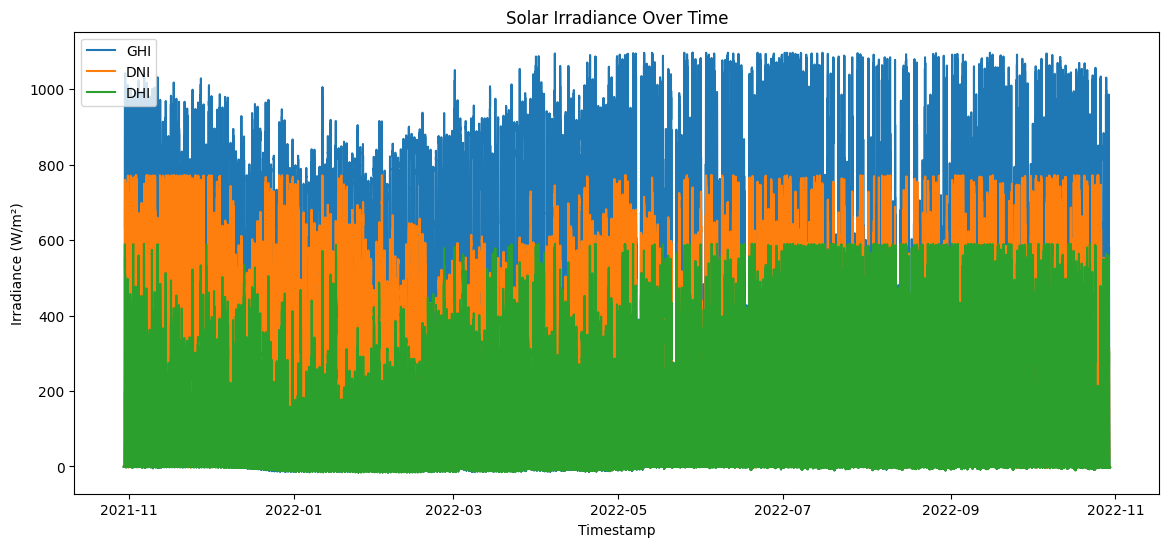

In [6]:
# --- 1. Line Chart: Solar Irradiance Over Time ---
plt.figure(figsize=(14, 6))
plt.plot(df_final.index, df_final['GHI'], label='GHI')
plt.plot(df_final.index, df_final['DNI'], label='DNI')
plt.plot(df_final.index, df_final['DHI'], label='DHI')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.title('Solar Irradiance Over Time')
plt.legend()
plt.show()

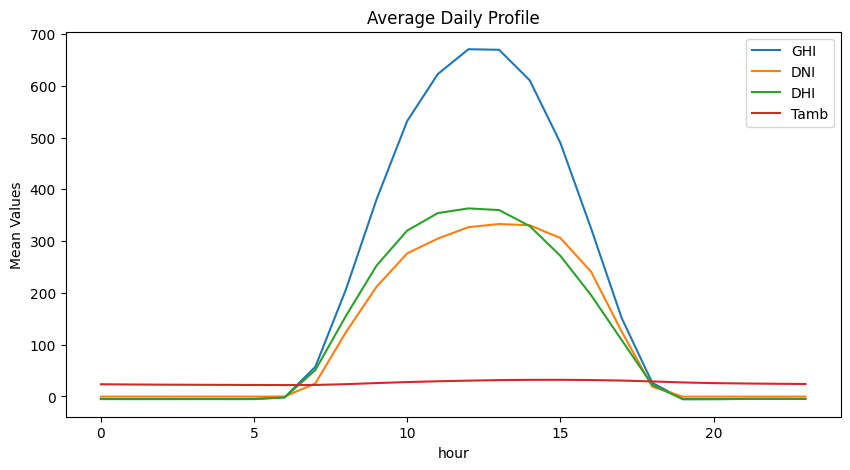

In [7]:
# --- 2. Diurnal (Hourly) Profile ---
df_final['hour'] = df_final.index.hour
hourly_mean = df_final.groupby('hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

hourly_mean.plot(kind='line', figsize=(10, 5), title='Average Daily Profile')
plt.ylabel('Mean Values')
plt.show()

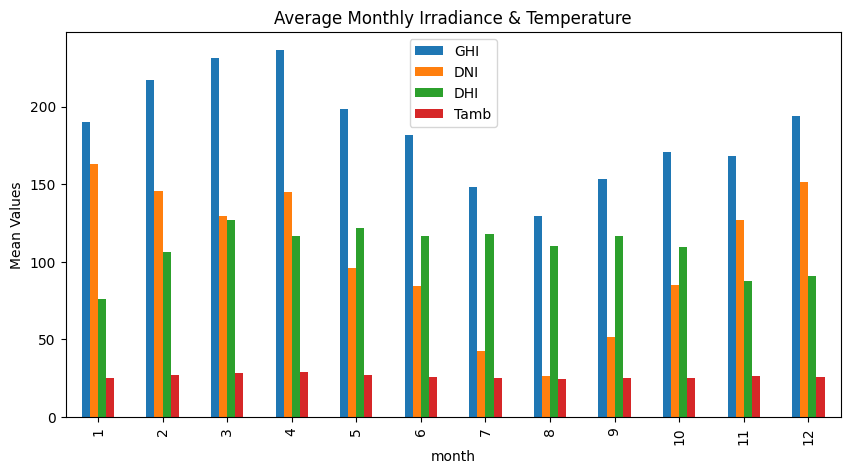

In [8]:
# --- 3. Monthly Trends ---
df_final['month'] = df_final.index.month
monthly_mean = df_final.groupby('month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_mean.plot(kind='bar', figsize=(10, 5), title='Average Monthly Irradiance & Temperature')
plt.ylabel('Mean Values')
plt.show()

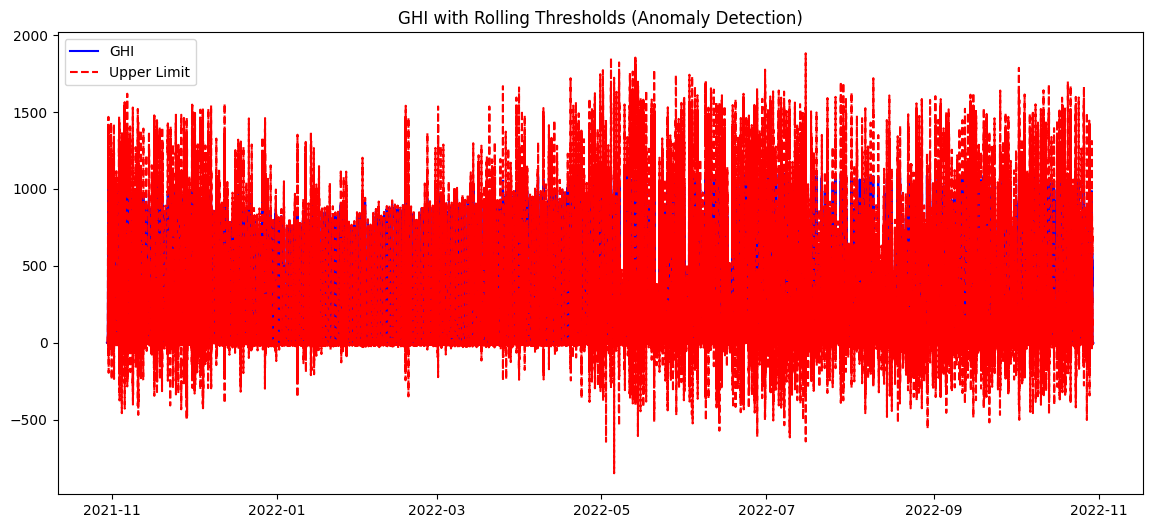

In [9]:
# --- 4. Rolling Mean & Anomaly Visualization ---
window = 24  # adjust based on sampling frequency (e.g., 24 for hourly)
ghi_mean = df_final['GHI'].rolling(window).mean()
ghi_std = df_final['GHI'].rolling(window).std()
upper = ghi_mean + 3 * ghi_std
lower = ghi_mean - 3 * ghi_std

plt.figure(figsize=(14, 6))
plt.plot(df_final.index, df_final['GHI'], label='GHI', color='blue')
plt.plot(df_final.index, upper, color='red', linestyle='--', label='Upper Limit')
plt.plot(df_final.index, lower, color='red', linestyle='--')
plt.title('GHI with Rolling Thresholds (Anomaly Detection)')
plt.legend()
plt.show()

# Cleaning Impact

## Impact of Cleaning the Solar  Panels


--- Average Module Irradiance Pre/Post Cleaning ---
1 = Cleaning Occurred, 0 = No Cleaning
                ModA        ModB
Cleaning                        
0         189.680780  181.598521
1         273.309252  277.231102


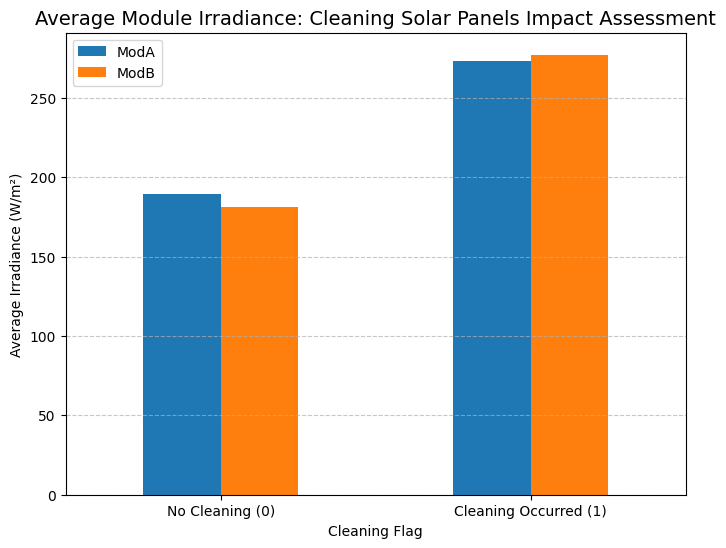

In [10]:
# Group by the Cleaning flag and calculate the mean ModA and ModB
cleaning_impact = df_final.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("\n--- Average Module Irradiance Pre/Post Cleaning ---")
print("1 = Cleaning Occurred, 0 = No Cleaning")
print(cleaning_impact)

# Plotting the impact
plt.figure(figsize=(8, 6))
cleaning_impact.plot(kind='bar', ax=plt.gca())

plt.title('Average Module Irradiance: Cleaning Solar Panels Impact Assessment', fontsize=14)
plt.ylabel('Average Irradiance (W/m²)')
plt.xlabel('Cleaning Flag')
plt.xticks([0, 1], ['No Cleaning (0)', 'Cleaning Occurred (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Impact of Cleaning the data 

                     ModA        ModB
Cleaning_Flag                        
Post-Clean     189.764194  181.693908
Pre-Clean      206.643095  198.114691


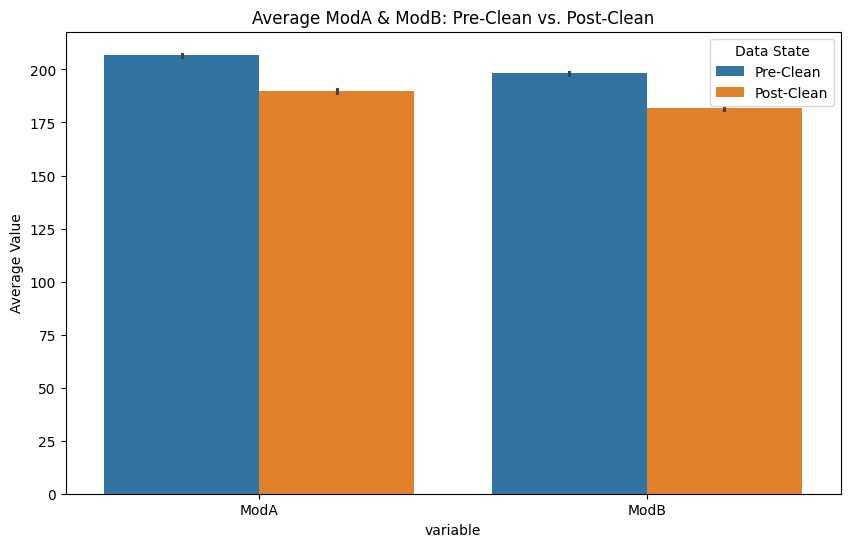

In [11]:
df_raw = pd.read_csv(f"./data/{FILE_NAME}")
df_new = pd.read_csv(f'./data/{COUNTRY_NAME}_clean.csv')

# Add flags
df_raw['Cleaning_Flag'] = 'Pre-Clean'
df_new['Cleaning_Flag'] = 'Post-Clean'

# Combine into one DataFrame for comparison
df_combined = pd.concat([df_raw, df_new])

# Group by flag and calculate mean
cleaning_impact = df_combined.groupby('Cleaning_Flag')[['ModA', 'ModB']].mean()
print(cleaning_impact)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_combined.melt(id_vars='Cleaning_Flag', value_vars=['ModA', 'ModB']),
    x='variable', 
    y='value', 
    hue='Cleaning_Flag',
)
plt.title('Average ModA & ModB: Pre-Clean vs. Post-Clean')
plt.ylabel('Average Value')
plt.legend(title='Data State')
plt.show()

# Correlation and Relationship Analysis

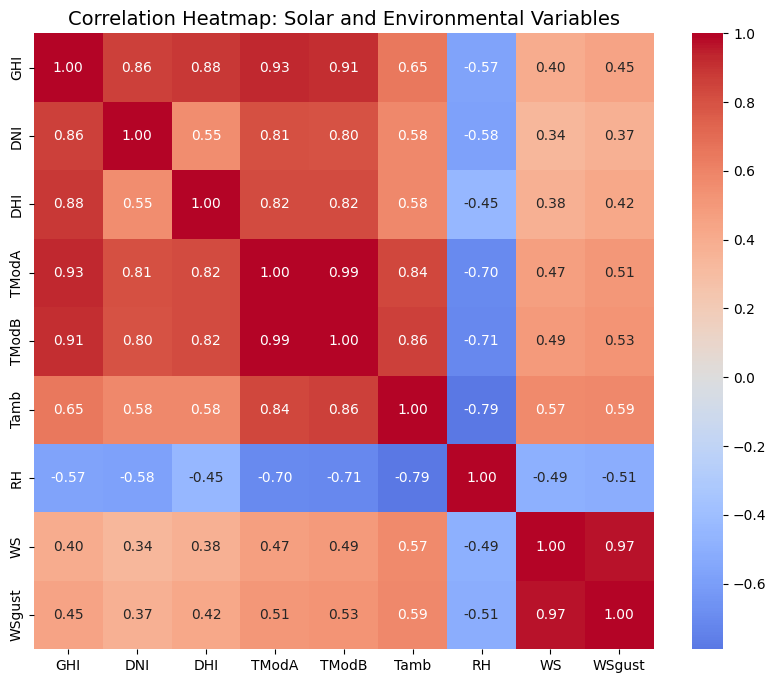

In [12]:
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'WSgust']
corr_matrix = df_final[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap: Solar and Environmental Variables', fontsize=14)
plt.show()

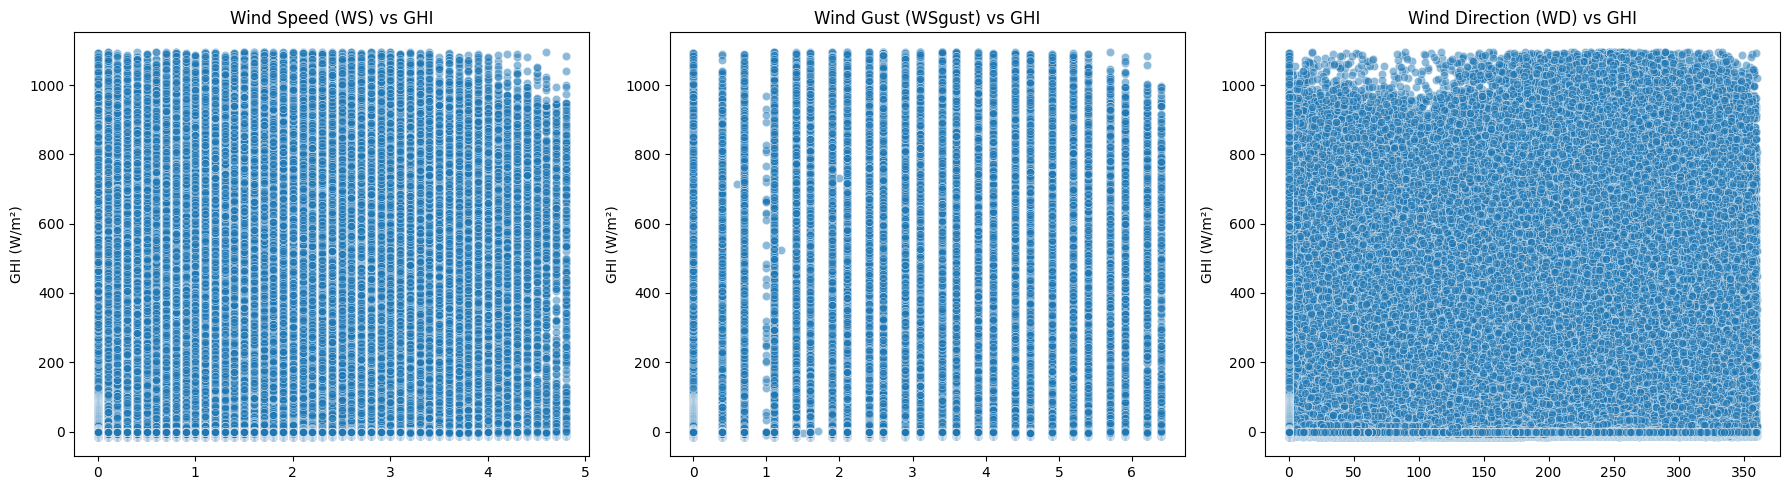

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_final, x='WS', y='GHI', ax=axes[0], alpha=0.5)
axes[0].set_title('Wind Speed (WS) vs GHI')

sns.scatterplot(data=df_final, x='WSgust', y='GHI', ax=axes[1], alpha=0.5)
axes[1].set_title('Wind Gust (WSgust) vs GHI')

sns.scatterplot(data=df_final, x='WD', y='GHI', ax=axes[2], alpha=0.5)
axes[2].set_title('Wind Direction (WD) vs GHI')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()


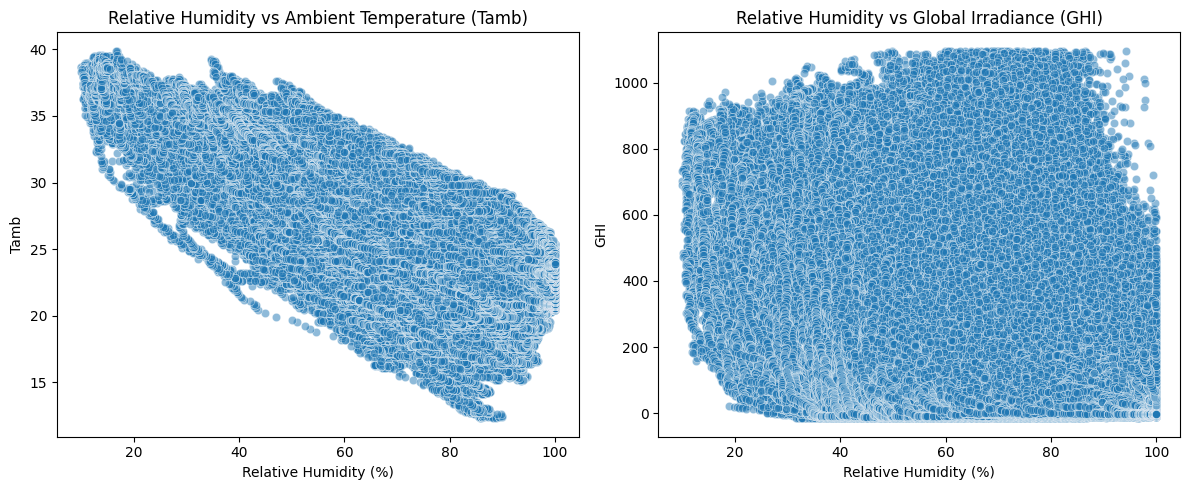

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df_final, x='RH', y='Tamb', ax=axes[0], alpha=0.5)
axes[0].set_title('Relative Humidity vs Ambient Temperature (Tamb)')

sns.scatterplot(data=df_final, x='RH', y='GHI', ax=axes[1], alpha=0.5)
axes[1].set_title('Relative Humidity vs Global Irradiance (GHI)')

for ax in axes:
    ax.set_xlabel('Relative Humidity (%)')
plt.tight_layout()
plt.show()


# Wind and Distribution Analysis

<Figure size 800x800 with 0 Axes>

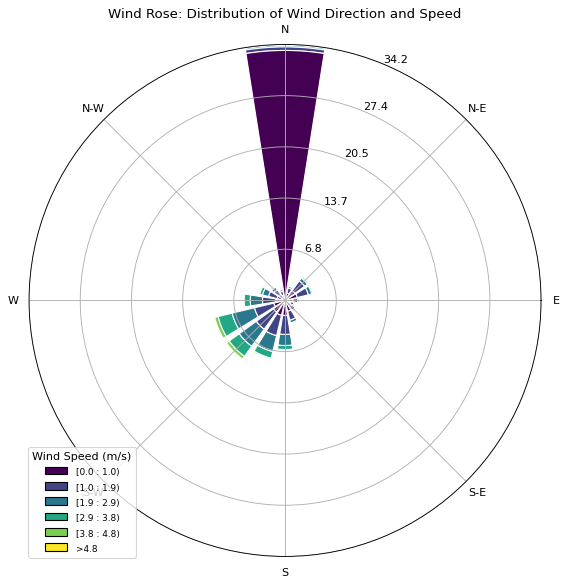

In [15]:
plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax()
ax.bar(df_final['WD'], df_final['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose: Distribution of Wind Direction and Speed')
ax.set_legend(title='Wind Speed (m/s)')
plt.show()

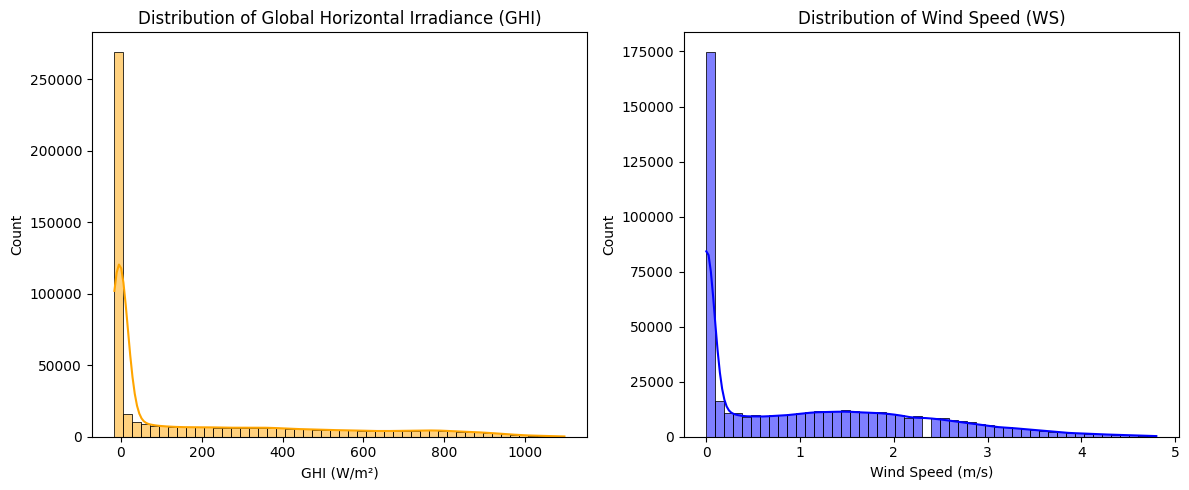

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_final['GHI'], bins=50, kde=True, ax=axes[0], color='orange')
axes[0].set_title('Distribution of Global Horizontal Irradiance (GHI)')
axes[0].set_xlabel('GHI (W/m²)')

sns.histplot(df_final['WS'], bins=50, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Distribution of Wind Speed (WS)')
axes[1].set_xlabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()


# Temperature Analysis

In [17]:
# --- 1. Create RH Bins ---
# Create 5 bins for RH (e.g., 0-20%, 20-40%, ..., 80-100%)
rh_bins = np.arange(0, 101, 20)
rh_labels = [f'{i}%-{i+20}%' for i in rh_bins[:-1]]

# Create a binned category column
df_final['RH_Bin'] = pd.cut(
    df_final['RH'], 
    bins=rh_bins, 
    labels=rh_labels, 
    include_lowest=True, 
    right=False
)

# --- 2. Calculate Mean Metrics per Bin ---
# Calculate the mean Tamb, TModA, and GHI for each RH bin
rh_influence_summary = df_final.groupby('RH_Bin', observed=False)[['Tamb', 'TModA', 'GHI']].mean()

print("\nAverage Temperature and GHI Across Relative Humidity Bins:")
print(rh_influence_summary.to_string(float_format='%.1f'))


Average Temperature and GHI Across Relative Humidity Bins:
          Tamb  TModA   GHI
RH_Bin                     
0%-20%    36.5   56.9 634.2
20%-40%   33.9   49.6 496.7
40%-60%   31.5   43.6 397.7
60%-80%   27.9   37.4 305.4
80%-100%  23.9   26.2  75.7


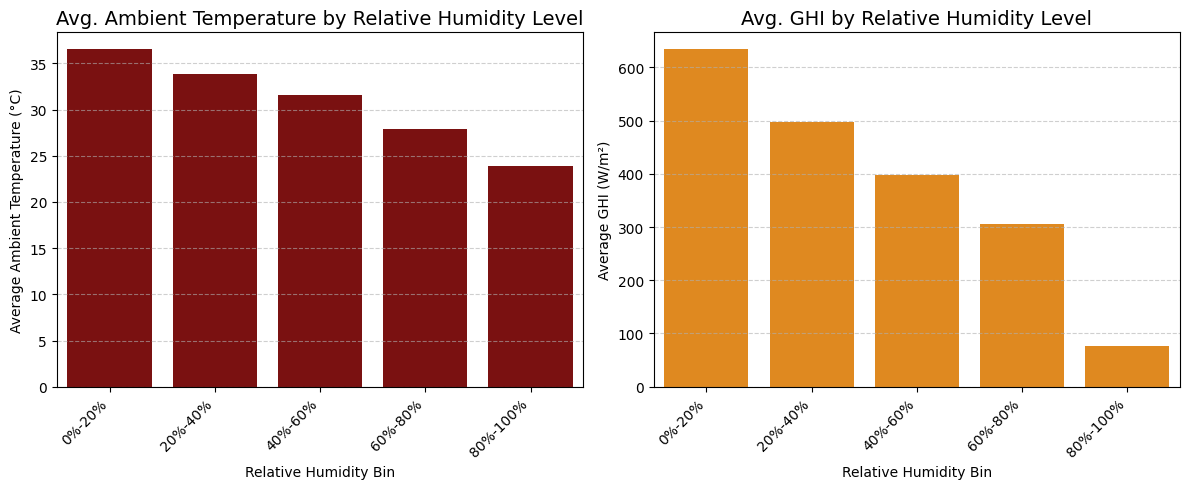

In [18]:
# --- 3. Plotting the Influence ---
# Use the summary table to plot the relationships

plt.figure(figsize=(12, 5))

# Plot 1: RH Bin vs. Temperature
plt.subplot(1, 2, 1)
sns.barplot(x=rh_influence_summary.index, y='Tamb', data=rh_influence_summary.reset_index(), color='darkred')
plt.title('Avg. Ambient Temperature by Relative Humidity Level', fontsize=14)
plt.xlabel('Relative Humidity Bin')
plt.ylabel('Average Ambient Temperature (°C)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Plot 2: RH Bin vs. Irradiance
plt.subplot(1, 2, 2)
sns.barplot(x=rh_influence_summary.index, y='GHI', data=rh_influence_summary.reset_index(), color='darkorange')
plt.title('Avg. GHI by Relative Humidity Level', fontsize=14)
plt.xlabel('Relative Humidity Bin')
plt.ylabel('Average GHI (W/m²)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Bubble Chart


--- Key Performance Indicators (KPIs): Bubble Chart ---


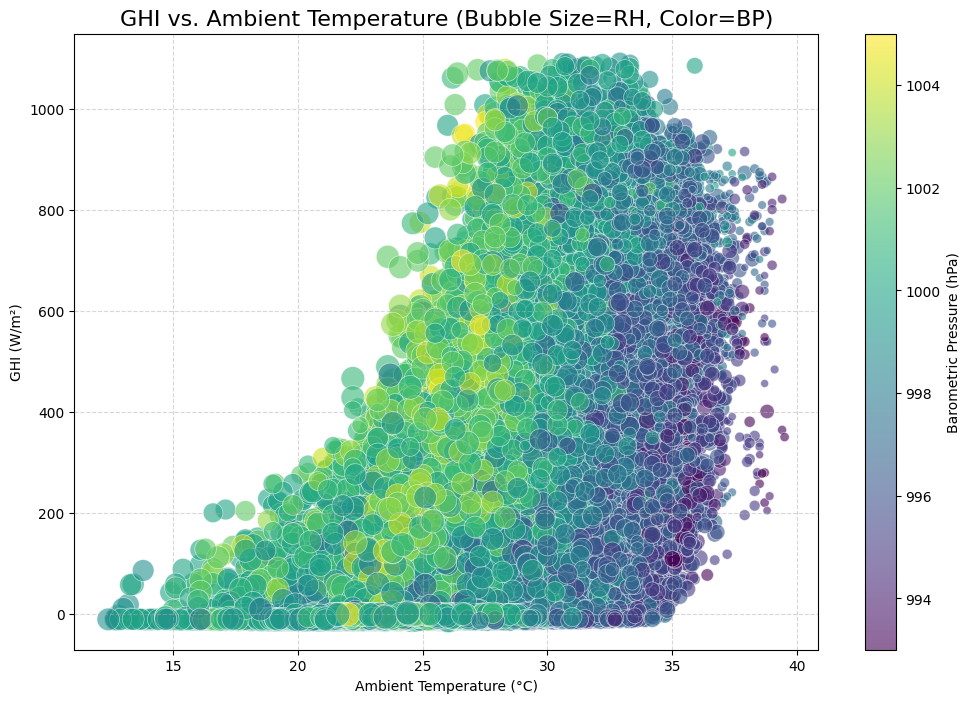

In [19]:
print("\n--- Key Performance Indicators (KPIs): Bubble Chart ---")

# --- 1. Data Sampling ---
# Use a sample of the data to keep the plot readable, as 
# plotting all points would result in a solid block of color.
df_sample = df_final.sample(n=30000, random_state=42) # Adjust n based on dataset size

# --- 2. Scaling for Visualization ---
# Scale the RH values for bubble size (s)
# Matplotlib requires size input to be area, not radius. Scaling RH up significantly.
rh_scaled = df_sample['RH'].clip(lower=1) * 3  # Ensure minimum size, scale up

plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter = plt.scatter(
    x=df_sample['Tamb'], 
    y=df_sample['GHI'], 
    s=rh_scaled,          # Bubble size = Scaled Relative Humidity
    c=df_sample['BP'],    # Color = Barometric Pressure
    cmap='viridis',       # Colormap for pressure
    alpha=0.6,
    edgecolors='w',
    linewidths=0.5
)

# Add color bar for Barometric Pressure
cbar = plt.colorbar(scatter, label='Barometric Pressure (hPa)')

plt.title('GHI vs. Ambient Temperature (Bubble Size=RH, Color=BP)', fontsize=16)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.grid(axis='both',linestyle='--', alpha=0.5)
plt.show()